### **1. Import the Required Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

ModuleNotFoundError: No module named 'tensorflow.python'

### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [2]:
train_dataset_path = 'C:/Users/Admin/Downloads/archive/Data/train'
validation_dataset_path = 'C:/Users/Admin/Downloads/archive/Data/test'

#### **ii. Load Image Datasets and Apply Augmentations**

In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 20

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 539 images belonging to 3 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 264 images belonging to 3 classes.


#### **iii. Get the Label Mappings**

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1 : normal
2 : squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


### **3. Plotting Sample Training Images**

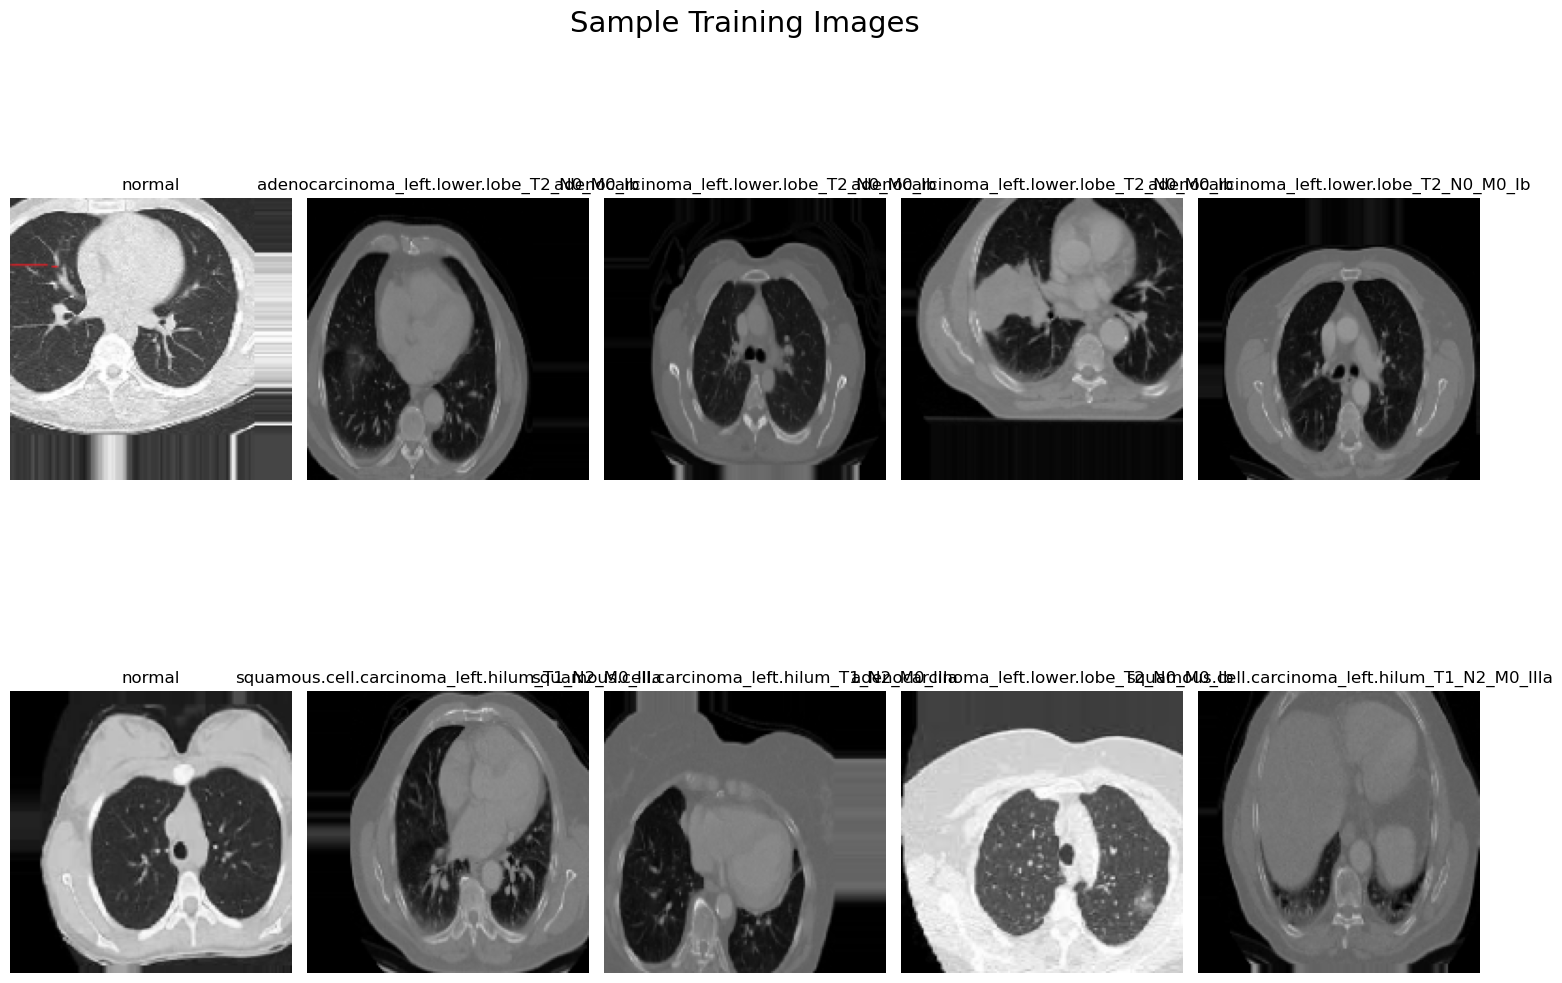

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### **4. Training a CNN Model**

Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

#### **i. Create a CNN Model**

In [8]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=3, activation='softmax')
    ])
    
    return model

In [9]:
cnn_model = create_model()

In [10]:
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 146, 146, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 146, 146, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 71, 71, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 71, 71, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 35, 35, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 33, 33, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,201,059 (8.40 MB)

 Trainable params: 2,200,611 (8.39 MB)

 Non-trainable params: 448 (1.75 KB)

None


#### **ii. Defining Callbacks**

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **iii. Defining the Optimizer**

In [12]:
optimizer = Adam(learning_rate=0.001)

#### **iv. Compile the Model**

In [13]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

#### **v. Training the Model**

In [14]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
27/27 - 68s - 3s/step - accuracy: 0.5770 - loss: 2.2124 - val_accuracy: 0.3598 - val_loss: 1.0499 - learning_rate: 0.0010
Epoch 2/50
27/27 - 57s - 2s/step - accuracy: 0.6160 - loss: 1.8997 - val_accuracy: 0.3409 - val_loss: 1.8457 - learning_rate: 0.0010
Epoch 3/50
27/27 - 59s - 2s/step - accuracy: 0.5955 - loss: 1.8298 - val_accuracy: 0.3523 - val_loss: 1.7604 - learning_rate: 0.0010
Epoch 4/50
27/27 - 60s - 2s/step - accuracy: 0.6382 - loss: 1.2522 - val_accuracy: 0.3409 - val_loss: 2.4728 - learning_rate: 0.0010
Epoch 5/50
27/27 - 60s - 2s/step - accuracy: 0.6642 - loss: 1.0085 - val_accuracy: 0.4545 - val_loss: 2.9372 - learning_rate: 0.0010
Epoch 6/50
27/27 - 61s - 2s/step - accuracy: 0.6085 - loss: 1.1729 - val_accuracy: 0.3409 - val_loss: 4.0397 - learning_rate: 0.0010
Epoch 7/50
27/27 - 54s - 2s/step - accuracy: 0.6512 - loss: 0.8404 - val_accuracy: 0.3371 - val_loss: 3.3885 - learning_rate: 3.1623e-04
Epoch 8/50
27/27 - 59s - 2s/step - accuracy: 0.6865 - loss: 0.644

### **5. Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [32]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# learning_rate = history.history['lr']

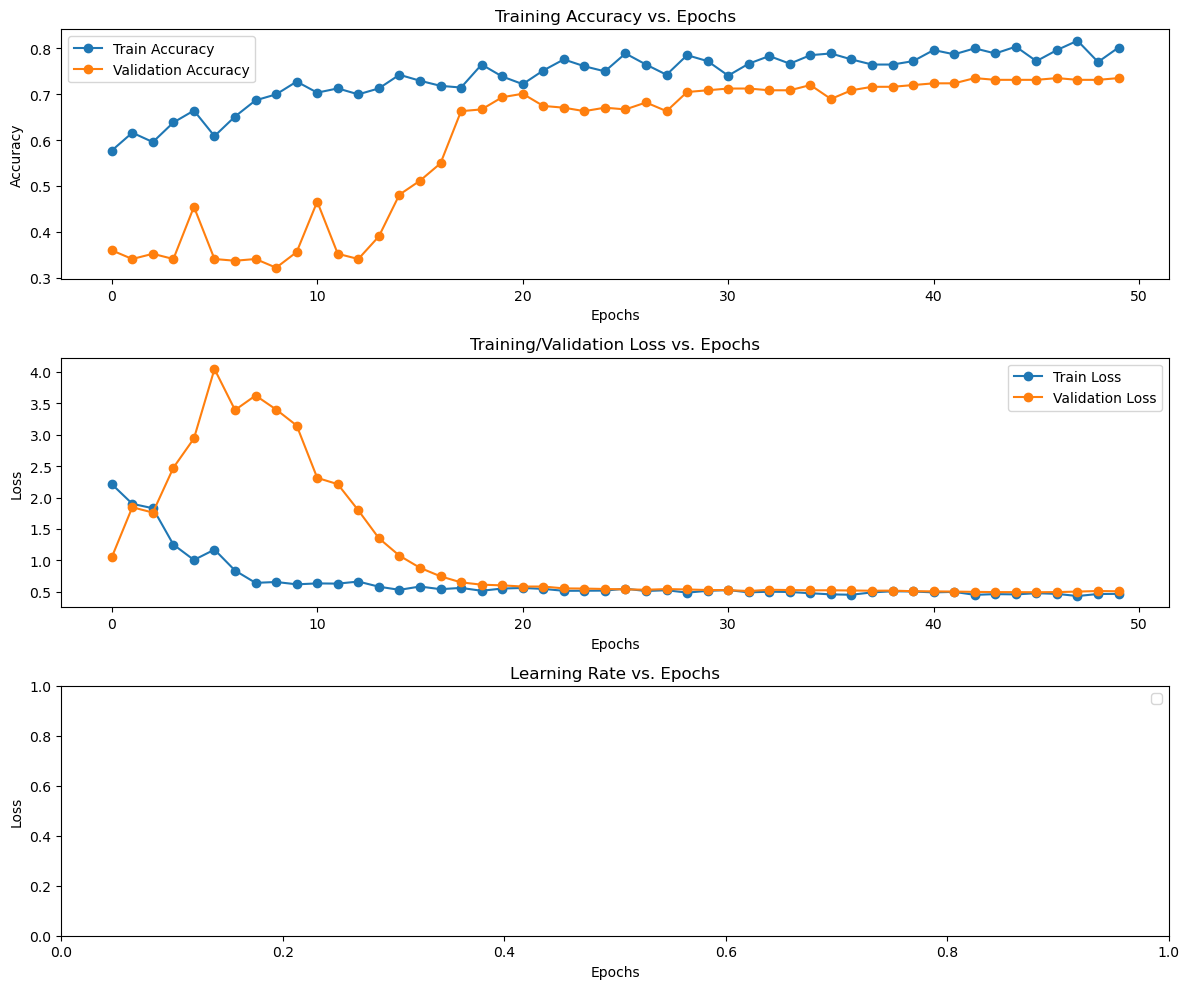

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### **6. Testing the Model on Test Set**

Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [17]:
test_dataset = 'C:/Users/Admin/Downloads/archive/Data/test'

In [18]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 264 images belonging to 3 classes.


### **7. Model Prediction on the Test Dataset**

In [19]:
predictions = cnn_model.predict(test_generator)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step


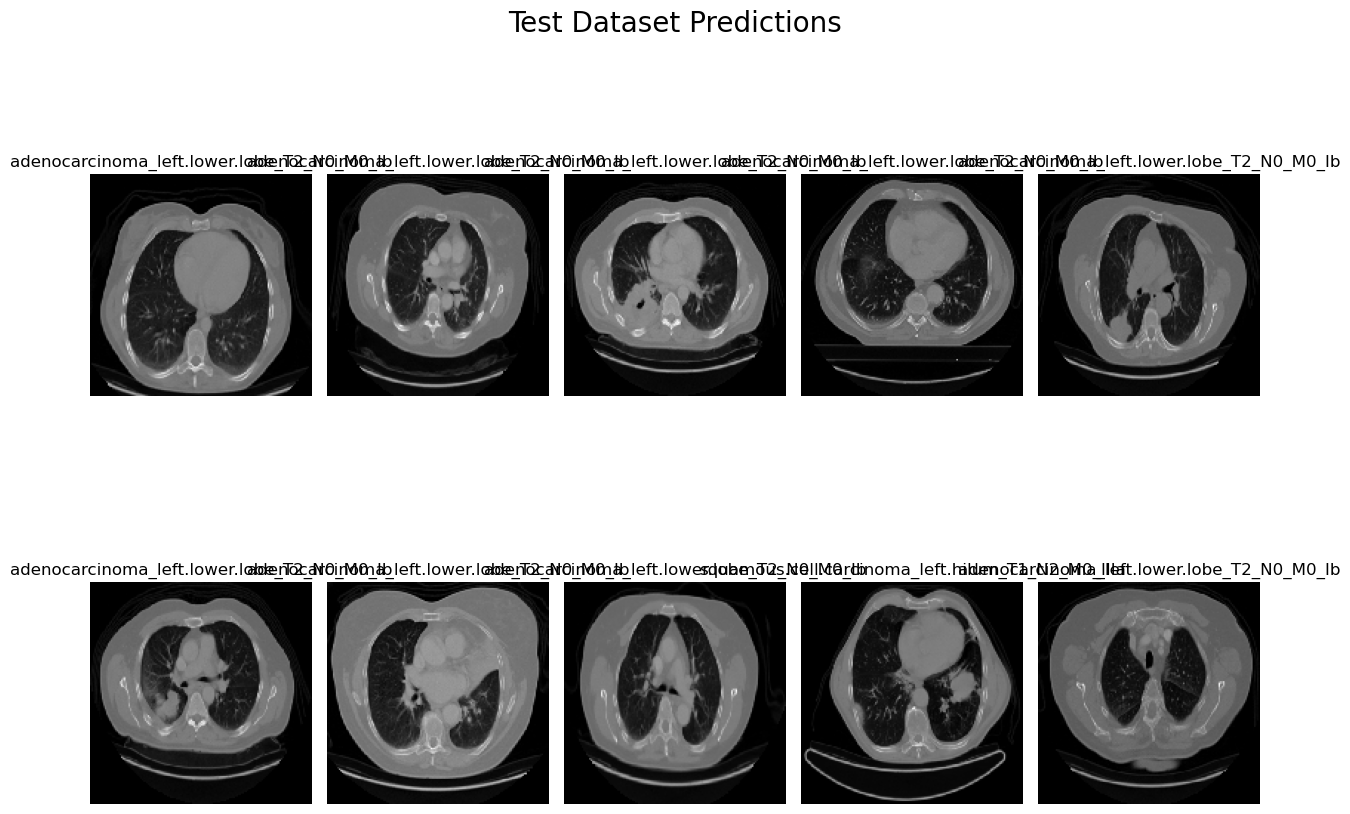

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [21]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.8585 - loss: 0.3882


In [22]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.5112007260322571
Test Accuracy: 0.7348484992980957


The test loss and test accuracy is the same as validation loss and validation accuracy at the last step since the testing and validation datasets are same.

### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [23]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

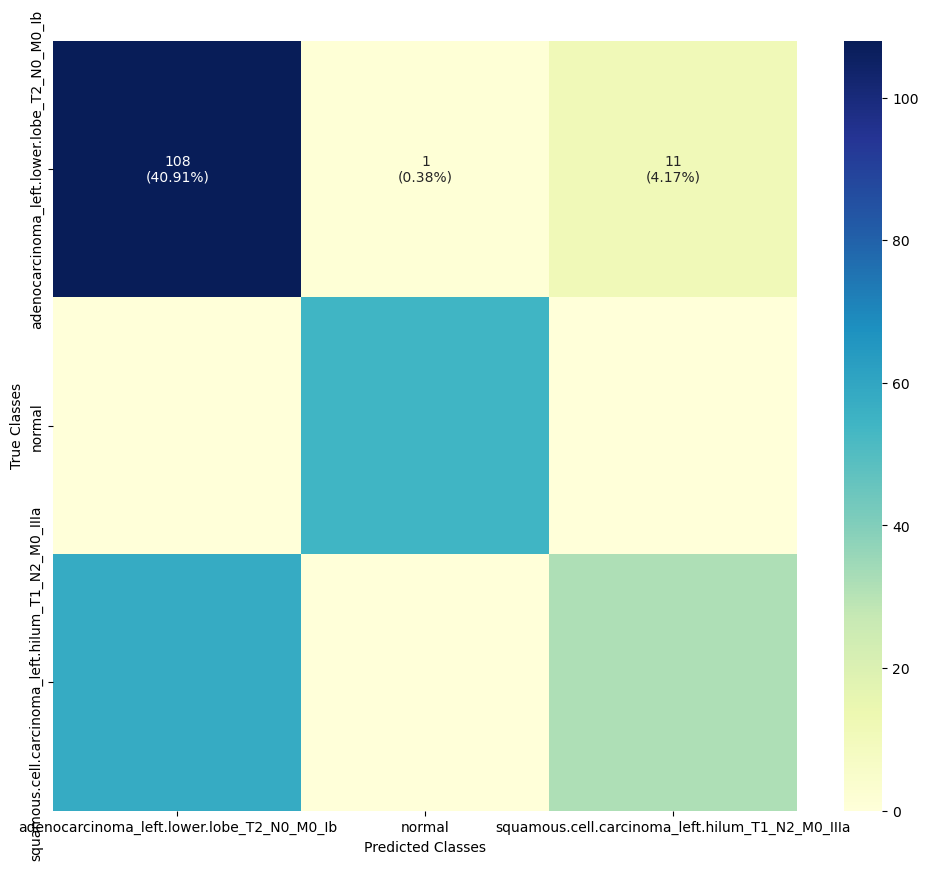

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are defined
# Compute confusion matrix
cf_mtx = confusion_matrix(y_true, y_pred)

# Compute group counts and percentages for annotations
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten() / np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]

# Reshape box_labels based on the shape of cf_mtx
rows, cols = cf_mtx.shape
box_labels = np.asarray(box_labels).reshape(rows, cols)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


In [25]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.65      0.90      0.76       120
                                          normal       0.98      1.00      0.99        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.74      0.36      0.48        90

                                        accuracy                           0.73       264
                                       macro avg       0.79      0.75      0.74       264
                                    weighted avg       0.75      0.73      0.71       264



In [26]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2

# Save the trained model
cnn_model.save('my_cnn_model5.h5')

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the test dataset
test_data_dir = 'C:/Users/Admin/Documents/lung-mini project final/ct scan/Data/test'

# Define parameters
input_shape = (150, 150, 3)
batch_size = 32

# Load the pre-trained model
model = load_model('F:/projects/lung-mini project final/ct scan/my_cnn_model5.h5')

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test dataset
accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", accuracy[1])

# Make predictions on the test dataset
test_generator.reset()  # Reset generator to ensure proper indexing
predicted_probabilities = model.predict(test_generator, steps=len(test_generator))
predicted_labels = np.argmax(predicted_probabilities, axis=1)
true_labels = test_generator.classes

# Print classification report
report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:\n", report)

# Print confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('\nPredicted Label')
plt.ylabel('True Label\n')
plt.title('Confusion Matrix\n')
plt.show()

ModuleNotFoundError: No module named 'tensorflow.python'